In [0]:
import torch.nn as nn
import torch.nn.functional as F
import torch
from torchsummary import summary
from torch.autograd import Variable
from logging import Logger
from skimage.color import rgb2lab, lab2rgb, rgb2gray, xyz2lab
from skimage.io import imsave
import torch.optim as optim

In [0]:
class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x


class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            double_conv(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x


class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()

        #  would be a nice idea if the upsampling could be learned too,
        #  but my machine do not have enough memory to handle all those weights
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX//2,
                        diffY // 2, diffY - diffY//2))
        
        # for padding issues, see 
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd

        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x

In [0]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.inc = inconv(n_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.up1 = up(1024, 256)
        self.up2 = up(512, 128)
        self.up3 = up(256, 64)
        self.up4 = up(128, 64)
        self.outc = outconv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return F.tanh(x)

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(1,2).to(device)

In [146]:

class Discriminator_1(nn.Module):
  def __init__(self):
    super(Discriminator_1,self).__init__()
    self.conv1 = nn.Sequential(
                                nn.Conv2d(2,32,kernel_size = 4,stride = 2),
                                nn.BatchNorm2d(32),
                                nn.MaxPool2d(2),
                                nn.LeakyReLU(0.5)
                              )
    self.conv2 = nn.Sequential(
                                nn.Conv2d(32,64,kernel_size = 4,stride = 2),
                                nn.BatchNorm2d(64),
                                nn.MaxPool2d(4),
                                
                                nn.LeakyReLU(0.5)
                              )
    self.conv3 = nn.Sequential(
                                nn.Conv2d(64,128,kernel_size = 3,stride = 1),
                                nn.BatchNorm2d(128),
                                nn.MaxPool2d(2),
                                nn.LeakyReLU(0.5)
                              )

    self.fc1 = nn.Sequential( 
                                nn.Linear(512, 256),
                                nn.LeakyReLU(0.2),
                                nn.Dropout(0.3)
                            )
    self.fc2 = nn.Sequential( 
                                nn.Linear(256, 128),
                                nn.LeakyReLU(0.2),
                                nn.Dropout(0.3)
                            )
    self.fc3 = nn.Sequential( 
                                nn.Linear(128, 1),            
        
                            )
    
  def forward(self,x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)

    x = x.view(-1,512)
    x = self.fc1(x)
    x = self.fc2(x)
    x = self.fc3(x)
    x = F.sigmoid(x)
    return x
discriminator = Discriminator_1().to(device)
summary(discriminator, (2, 256, 256)
)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 127, 127]           1,056
       BatchNorm2d-2         [-1, 32, 127, 127]              64
         MaxPool2d-3           [-1, 32, 63, 63]               0
         LeakyReLU-4           [-1, 32, 63, 63]               0
            Conv2d-5           [-1, 64, 30, 30]          32,832
       BatchNorm2d-6           [-1, 64, 30, 30]             128
         MaxPool2d-7             [-1, 64, 7, 7]               0
         LeakyReLU-8             [-1, 64, 7, 7]               0
            Conv2d-9            [-1, 128, 5, 5]          73,856
      BatchNorm2d-10            [-1, 128, 5, 5]             256
        MaxPool2d-11            [-1, 128, 2, 2]               0
        LeakyReLU-12            [-1, 128, 2, 2]               0
           Linear-13                  [-1, 256]         131,328
        LeakyReLU-14                  [

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [0]:
# optimizers

optimizer_G = optim.Adam(model.parameters(),
                             lr=0.01, betas=(0.5, 0.999),
                             eps=1e-8)
optimizer_D = optim.Adam(discriminator.parameters(),
                             lr=0.01, betas=(0.5, 0.999),
                             eps=1e-8)

In [0]:
#losses
mse = torch.nn.MSELoss()
L1 = torch.nn.L1Loss()
bce = torch.nn.BCELoss()

In [8]:
!pip install wget
import wget
wget.download('https://storage.googleapis.com/kaggle-datasets/5857/252786/fruits.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1548833389&Signature=V%2FAItCBgONDFg%2FWILY0WqFzc6WzJK6d7Fo7cUzMczZtS%2BqeRZoCszbEQl3EoyB5jlKjeE%2Fl36NKLfT1n04hPpvgymhCeKx1UhxyOa1g8frhkflM6qf1sfk0TelU%2Fk5miVNEOPI5mr2mLAip2mvhS70lQYDdV5yUlKldFDo5m9boOokma3W52KQkvMmYCX2HnzrSgeVswfK%2B0Agw2TGFb4xVUzjGvTIgZpCmxN3bhcZpqeJGij%2Fet7KiCrrRibhNiYeFh72U%2BrUc3nELEqKo43nTWBKB0%2B9lR682Z1M4WYFiqPH4s%2FR6FfxAqPSkwUM6crtMWKO5jjy2XmVDsyv767A%3D%3D')

'fruits (1).zip'

In [0]:
import os
import zipfile
zip_ref = zipfile.ZipFile('/content/fruits.zip', 'r')
zip_ref.extractall(os.getcwd())
zip_ref.close()

In [0]:
def ones_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = Variable(torch.ones(size, 1))
    data = data.type(torch.cuda.FloatTensor)
    return data

def zeros_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = Variable(torch.zeros(size, 1))
    data = data.type(torch.cuda.FloatTensor)
    return data

In [0]:
import cv2
from torch.utils.data import Dataset, DataLoader
class DataLoader(Dataset):
  def __init__(self,a,root_dir):
    self.a = a
    self.root_dir = root_dir
  def __len__(self):
      return len(self.a)
  def __getitem__(self, idx):
      img_name = os.path.join(self.root_dir, self.a[idx])
      target = cv2.imread(img_name)
      target = cv2.resize(target,(256,256))
      input_img = rgb2lab(1.0/255*target)[:,:,0]
      target = rgb2lab(1.0/255*target)[:,:,1:]
      target = target/128
      return input_img,target

In [0]:
import os
root_dir = '/content/fruits-360/Training/Apple Braeburn'
a = os.listdir(root_dir)
dataset = DataLoader(a,root_dir)
dataloader = torch.utils.data.DataLoader(dataset, batch_size = 1, shuffle = True)

In [13]:
import os
print(os.listdir('/content/fruits-360/Training/'))

['Plum 2', 'Banana Lady Finger', 'Plum 3', 'Papaya', 'Apple Granny Smith', 'Tomato 1', 'Cherry Wax Yellow', 'Tomato 2', 'Maracuja', 'Pineapple', 'Tangelo', 'Avocado ripe', 'Pear Kaiser', 'Kaki', 'Apple Golden 3', 'Physalis', 'Carambula', 'Pear Abate', 'Redcurrant', 'Pomelo Sweetie', 'Cherry 2', 'Nectarine', 'Pear Monster', 'Grape White 2', 'Apple Red 1', 'Apricot', 'Grapefruit Pink', 'Peach Flat', 'Apple Golden 1', 'Mango', 'Grapefruit White', 'Passion Fruit', 'Cherry Wax Red', 'Peach', 'Pear', 'Mangostan', 'Pear Williams', 'Melon Piel de Sapo', 'Tomato Maroon', 'Apple Red Yellow 1', 'Guava', 'Grape White 3', 'Rambutan', 'Cactus fruit', 'Raspberry', 'Kiwi', 'Apple Red 3', 'Clementine', 'Apple Braeburn', 'Grape White 4', 'Dates', 'Lychee', 'Tomato 3', 'Apple Red 2', 'Tomato Cherry Red', 'Walnut', 'Peach 2', 'Physalis with Husk', 'Cocos', 'Pineapple Mini', 'Apple Red Yellow 2', 'Hazelnut', 'Huckleberry', 'Mulberry', 'Lemon', 'Lemon Meyer', 'Cantaloupe 2', 'Pomegranate', 'Pepino', 'Avocad

In [0]:
!mkdir generated

In [0]:
torch.backends.cudnn.benchmark=True
import numpy as np
import cv2
from tqdm.autonotebook import tqdm
# optimizers

optimizer_G = optim.RMSprop(model.parameters(),
                             lr=0.1)
optimizer_G1 = optim.Adam(model.parameters(),
                             lr=0.1)
optimizer_D = optim.Adam(discriminator.parameters(),
                             lr=0.00003,betas=(0.5, 0.999),
                             eps=1e-8)
for epoch in range(50):
    for n_batch,(input_img,output_img) in enumerate(dataloader):
        N = input_img.size(0)
        #loss for generator 
        input_img = input_img.view(N,1,256,256)
        input_img = input_img.type(torch.cuda.FloatTensor)
        output_img = output_img.view(N,2,256,256)
        output_img = output_img.type(torch.cuda.FloatTensor)
        
        if(n_batch%100 == 0):
          # train Discriminator B --> C
            discriminator.train()
            
            optimizer_D.zero_grad()
            real_image = discriminator(output_img)
            
            loss_real = bce(real_image , zeros_target(N))
            fake_image = model(input_img)
            fake_label = discriminator(fake_image)
            
            loss_fake = bce(fake_label , ones_target(N))
            loss_B = (loss_real + loss_fake) / 2
            loss_b = loss_B
            loss_b.backward()
            optimizer_D.step()

        optimizer_G1.zero_grad()
        fake_image = model(input_img)
        output = discriminator(fake_image)
        loss_d = bce(output , ones_target(N))
        loss_L1 = L1(fake_image,output_img)
        loss_mse = mse(fake_image,output_img)
        loss_g = 50*loss_d + 10*loss_L1 + 10*loss_mse
        
        loss_g.backward(retain_graph = True)
        optimizer_G1.step()
        
        if(n_batch%100==0):
          print('epochs : {}'.format(epoch) ,  'g_error : {}'.format(loss_g) , 'discriminator_error :{}'.format(loss_B))
       
    torch.optim.lr_scheduler.StepLR(optimizer_D, 1, gamma=1.1, last_epoch=-1)
    torch.optim.lr_scheduler.StepLR(optimizer_G, 2, gamma=0.9, last_epoch=-1)
    if(epoch%1==0):
        model.eval()
        image,_ = dataset[4]
        image = torch.from_numpy(image)
        image = image.type(torch.cuda.FloatTensor)
        image = image.view(1,1,256,256)
        target = model(image).detach()
        b = target.to(torch.device("cpu"))
        b = b.numpy()
        b = np.reshape(b,(256,256,2))
        cur = np.zeros((256, 256, 3))
        image = image.to(torch.device("cpu"))
        image = image.numpy()
        cur[:,:,0] = image
        cur[:,:,1:] = (b*128)
        d = lab2rgb(cur)
        d =d*255
        cv2.imwrite('./generated/{}.png'.format(epoch),d)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


epochs : 0 g_error : 50.697174072265625 discriminator_error :0.6577025651931763
epochs : 0 g_error : 51.912811279296875 discriminator_error :0.6318631172180176
epochs : 0 g_error : 51.632835388183594 discriminator_error :0.6277487277984619
epochs : 0 g_error : 52.378028869628906 discriminator_error :0.6359759569168091
epochs : 0 g_error : 51.557865142822266 discriminator_error :0.659159779548645
epochs : 1 g_error : 52.35901641845703 discriminator_error :0.6356384754180908
epochs : 1 g_error : 52.24445343017578 discriminator_error :0.636372447013855
epochs : 1 g_error : 52.089290618896484 discriminator_error :0.6093904376029968
epochs : 1 g_error : 51.479549407958984 discriminator_error :0.6384469270706177
epochs : 1 g_error : 51.230159759521484 discriminator_error :0.6462578773498535
epochs : 2 g_error : 52.1240348815918 discriminator_error :0.6200084686279297
epochs : 2 g_error : 51.094444274902344 discriminator_error :0.6235784292221069
epochs : 2 g_error : 51.18182373046875 discrim

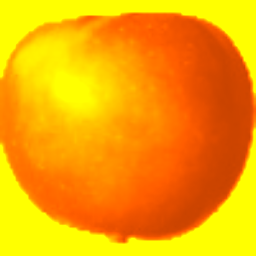

In [150]:
from IPython.display import Image
Image('/content/generated/0.png')